<a href="https://colab.research.google.com/github/StefanMalv/INFO284_SemesterOppgave_2025V/blob/main/25_03_2025-DEL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()  # Manually upload "Hotel_Reviews.csv"

Saving Hotel_Reviews.csv to Hotel_Reviews (1).csv


In [4]:
!pip install nltk

In [5]:
### Importing Libraries

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [6]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

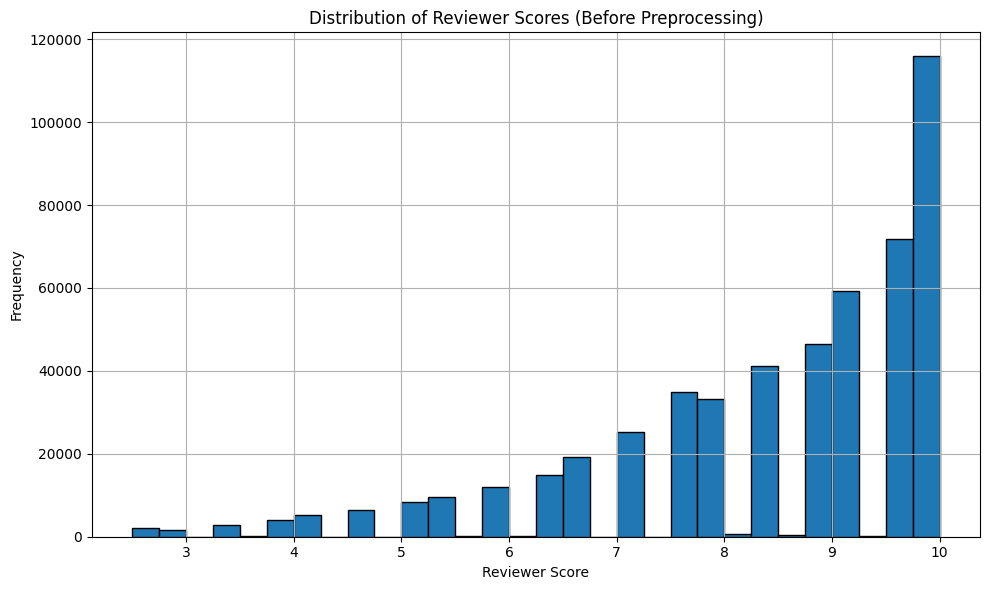

In [9]:
# Load the dataframe before using it
df = pd.read_csv("Hotel_Reviews.csv")

plt.figure(figsize=(10, 6))
df["Reviewer_Score"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Reviewer Scores (Before Preprocessing)")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
### Preprocessing Function
def preprocess_data(filepath="Hotel_Reviews.csv", test_size=0.2, random_state=42):
    df = pd.read_csv(filepath)
    df["Positive_Review"] = df["Positive_Review"].astype(str)
    df["Negative_Review"] = df["Negative_Review"].astype(str)
    df["reviews"] = df["Positive_Review"] + " " + df["Negative_Review"]

    # Most scores are above 7, so using 7 as the threshold helps capture truly negative reviews and keeps the classes balanced.
    df["Bad_reviews"] = df["Reviewer_Score"].apply(lambda x: 1 if x <= 7 else 0)


    df = df[["reviews", "Bad_reviews"]]
    df["reviews"] = (
        df["reviews"]
        .str.replace("No Negative", "", regex=False)
        .str.replace("No Positive", "", regex=False)
    )

    df.dropna(subset=["reviews"], inplace=True)
    df.drop_duplicates(subset=["reviews"], inplace=True)  # Removing duplicate reviews

    def clean_text(text):
        keep_words = {"not", "no", "never"}
        text = text.lower()
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        words = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        filtered_words = [w for w in words if (w not in stop_words) or (w in keep_words)]
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        return " ".join(lemmatized_words)

    df["Reviews_clean"] = df["reviews"].apply(clean_text)
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df["Bad_reviews"])
    return train_df, test_df


In [12]:
### Load and Preprocess Data
train_df, test_df = preprocess_data("Hotel_Reviews.csv")


In [13]:
print("Shape of the training data:", train_df.shape)
print("Shape of the testing data:", test_df.shape)
print("\nFirst 5 rows of the training data:")
print(train_df.head())
# print("\nInformation about the training data:")
# print(train_df.info())
# print("\nDescriptive statistics of the training data:")
# print(train_df.describe())


Shape of the training data: (399396, 3)
Shape of the testing data: (99849, 3)

First 5 rows of the training data:
                                                  reviews  Bad_reviews  \
142062                       Room was upgraded for free              0   
449040   Friendly and helpful staff We appreciated the...            0   
378939   Next to Westbahnhof Very convenient to do som...            0   
173941    I have been promised at the front desk to se...            1   
471929   Great location Very good service in the recap...            0   

                                            Reviews_clean  
142062                                 room upgraded free  
449040  friendly helpful staff appreciated extra thing...  
378939  next westbahnhof convenient shopping visit are...  
173941         promised front desk send room item not get  
471929  great location good service recaption simple room  


In [14]:
# TF-IDF Vectorization with bigrams
# Justification for limit: 5000 features allow capturing relevant patterns without excessive computation.
# With 5000, we reduce the chance of overfitting since this is a large dataset.
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Reviews_clean"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Reviews_clean"])

In [15]:
y_train = train_df["Bad_reviews"]
y_test = test_df["Bad_reviews"]

In [16]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [17]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (TF-IDF)")

--- Logistic Regression (TF-IDF) Evaluation ---
Accuracy: 0.8853669040250779
Precision: 0.7326425715917435
Recall: 0.5236456936264505
F1 Score: 0.610759708902945
Confusion Matrix:
[[79423  3277]
 [ 8169  8980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     82700
           1       0.73      0.52      0.61     17149

    accuracy                           0.89     99849
   macro avg       0.82      0.74      0.77     99849
weighted avg       0.88      0.89      0.88     99849



In [18]:
# Train and Evaluate Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)")

--- Naive Bayes (TF-IDF) Evaluation ---
Accuracy: 0.8737894220272612
Precision: 0.7087886858297364
Recall: 0.4500553968161409
F1 Score: 0.5505385548184607
Confusion Matrix:
[[79529  3171]
 [ 9431  7718]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     82700
           1       0.71      0.45      0.55     17149

    accuracy                           0.87     99849
   macro avg       0.80      0.71      0.74     99849
weighted avg       0.86      0.87      0.86     99849



In [19]:
# Train and Evaluate Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=30, random_state=42) #Max depth added to cap training time and to avoid overfitting.
dt_model.fit(X_train_tfidf, y_train)
evaluate_model(dt_model, X_test_tfidf, y_test, "Decision Tree (TF-IDF)")

--- Decision Tree (TF-IDF) Evaluation ---
Accuracy: 0.8465683181604222
Precision: 0.5889504911973543
Recall: 0.3530818123505744
F1 Score: 0.44148742253007656
Confusion Matrix:
[[78474  4226]
 [11094  6055]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     82700
           1       0.59      0.35      0.44     17149

    accuracy                           0.85     99849
   macro avg       0.73      0.65      0.68     99849
weighted avg       0.83      0.85      0.83     99849



In [20]:
# LSTM Model Training
max_vocab = 10000    # Limit to top 10,000 most frequent tokens to reduce memory & overfitting
max_len = 100        # Pad/truncate reviews to 100 tokens for consistent input shape
embedding_dim = 100  # 100-dim word embeddings balance expressiveness and efficiency

In [21]:
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>") # Use top 10k words; mark unknown words as <OOV>
tokenizer.fit_on_texts(train_df["Reviews_clean"])             # Build word index from training reviews only

In [22]:
X_train_seq = tokenizer.texts_to_sequences(train_df["Reviews_clean"])   # Convert words to integer sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["Reviews_clean"])     # Apply same tokenizer to test data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # Pad/truncate to length 100
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [34]:
# Build and Train LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim),# Word embeddings
    LSTM(64, return_sequences=False),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid') # Binary classification output
])

In [35]:
lstm_model.build(input_shape=(None, max_len)) # Manually build the model with input shape: batch x sequence_length
lstm_model.summary()                          # Now shows actual layer sizes & parameter counts

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Evaluate LSTM Model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0) # Evaluate loss & accuracy on test set
print("--- LSTM (Word Embeddings) Evaluation ---")
print("Accuracy:", lstm_acc)
y_pred_lstm_prob = lstm_model.predict(X_test_pad)                        # Get predicted probabilities
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)                       # Convert to binary predictions (threshold = 0.5)
print("Precision:", precision_score(y_test, y_pred_lstm))
print("Recall:", recall_score(y_test, y_pred_lstm))
print("F1 Score:", f1_score(y_test, y_pred_lstm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm))

--- LSTM (Word Embeddings) Evaluation ---
Accuracy: 0.8276798129081726
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Precision: 0.43387470997679817
Recall: 0.010904425914047467
F1 Score: 0.021274175199089876
Confusion Matrix:
[[82456   244]
 [16962   187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     82700
           1       0.43      0.01      0.02     17149

    accuracy                           0.83     99849
   macro avg       0.63      0.50      0.46     99849
weighted avg       0.76      0.83      0.75     99849

